# **2.155 Neural Networks Demo**

This 2.155 Convolutional Neural Networks demo is intended to get you started developing neural network architectures. We will use the microstructure property prediction prolem as the domain of choice. It will help familiarize you with deep learning and give you some insight into the intriguing metamaterials design domain.

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>


## **Demo Description**
In this demo, we are giving you a dataset of orthotropic microstructures represented by 50x50 pixelated matrices and asking you to predict various quantities of interest (volume fraction and four independent components of the stiffness matrix - more details below). The microstructures are composed of void (air) and solid (Young’s modulus = 1 (normalized), Poisson’s ratio = 0.49).  


Some sample microstructures with corresponding volume fractions labeled:
<img src="https://drive.google.com/uc?export=view&id=195S_tnidgN-aAZBMDXXI68vxm51ez9rd">

This data was sourced and adapted from the following works:

    Wang, L., Chan, Y.-C., Ahmed, F., Liu, Z., Zhu, P., & Chen, W. (2020).  Deep generative modeling for mechanistic-based learning and design of metamaterial systems.  Computer Methods in Applied Mechanics and Engineering, 372, 113377.
    Wang, L., Chan, Y.-C., Liu, Z., Zhu, P., & Chen, W. (2020). Data-driven metamaterial design with Laplace-Beltrami spectrum as “shape-DNA”. Structural and Multidisciplinary Optimization, 1-16.



## **Background on Stiffness Matrices for 2D orthotropic materials**
You can ignore this if you want, but it provides good context.




The stiffness matrix relates the normal stresses (sigma) shear stresses (tau), normal strains (epsilon) and shear strains(epsilon) of a material. In a 3-dimensional material, we have 3 directions of each component. In this case, our stiffness matrix is as follows:

<img src="https://drive.google.com/uc?export=view&id=1mJQR-lPO-VbYgkl-WP_n-yAxchBZF7LQ" width="400"/>

Recall: "A material is orthotropic if its mechanical or thermal properties are unique and independent in three mutually perpendicular directions." For example, wooden logs are orthotropic since properties differ in three perpendicular directions (axial, radial, and circumferential). Similarly cold rolled sheet metal is orthotropic since its material properties differ in the direction it was rolled and the two transverse directions. For orthotropic materials, we can make the following simplifaction to the stiffness matrix:

<img src="https://drive.google.com/uc?export=view&id=12fbuMDYYaAkXDvSzxlLy47d60i5fB7t2" width="400"/>

Finally, we make the simplification to the two dimensional case. Our new stiffness matrix only has 4 terms relating the two normal stresses and one shear stress to the two normal strains and one shear strain.

<img src="https://drive.google.com/uc?export=view&id=1uGBRrVWrp20xV7O2hnpBDyHGIeEwGRh6" width="270"/>

Given an image of a mictrostructure we are asking you to predict the C11, C12, C22, and C66 values of its stiffness matrix, as well as the volume fraction. We will provide you a training dataset of microstructures with known stiffness values and volume fractions. We will also give you a testing dataset of microstructures with unknown stiffness values and volume fractions. Your job is to train a machine learning algorithm to predict these unknown quantities for each microstructure in the test set.

## **Setting Things Up**

Neural Networks are generally much faster to train on GPU rather than CPU.

<font color='red'>**To do: Make sure to use GPU when running on colab. To enable GPU, go to the "Runtime" menu above and select the "Change runtime type" option and select GPU. This will speed up the training significantly.**

That's it we're ready to move on to coding!

## **Let's Get Coding!**

We will be using pytorch, a machine learning and AI library to make it easy for us to train machine learning models.




In [84]:
%pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note: you may need to restart the kernel to use updated packages.


Let's load the data. We have a train set and a test set. We give you both the X (images) and Y values (properties) for both datasets. Note, however, that Y test values would conventionally be unavailable in a hackathon/challenge problem or if making predicitons in a real-world application setting.

In [85]:
!git clone https://github.com/Lyleregenwetter/2.155-Demo-Materials

X = np.load('2.155-Demo-Materials/Metamaterials Demo/X.npy')
Y = np.load('2.155-Demo-Materials/Metamaterials Demo/Y.npy')


fatal: destination path '2.155-Demo-Materials' already exists and is not an empty directory.


Note that the data is placed in two separate folders Train and Test.

In [86]:
X_test = np.load('2.155-Demo-Materials/Metamaterials Demo/X_test.npy')
Y_test = np.load('2.155-Demo-Materials/Metamaterials Demo/Y_test.npy')

Now let's see how many datapoints we have:

In [87]:
print('Shape of training data: ',X.shape)
print('Shape of test data: ', X_test.shape)


Shape of training data:  (7438, 50, 50)
Shape of test data:  (24386, 50, 50)


As you can see we 7438 datapoints which are images with size 50px x 50px. Similarly we have 24386 test images with the same size. Now that we have our data loaded and have viewed the distribution of deflections, let's plot some of the metamaterial structures, We label the corresponding volume fractions for each sample.

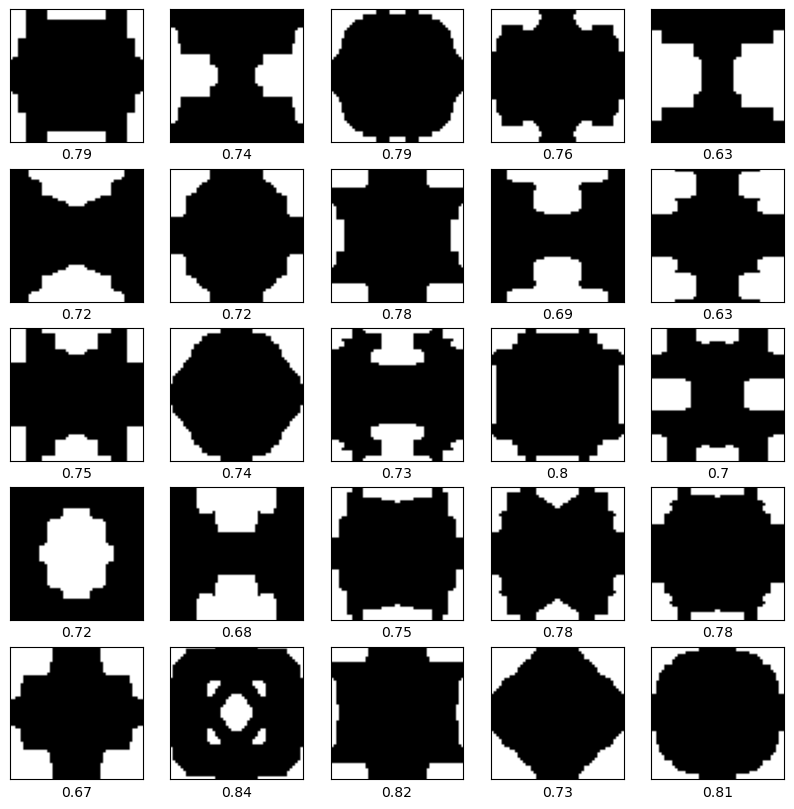

In [88]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i][:,:], cmap=plt.cm.binary)
    plt.xlabel(np.round(Y[i, 4],2))
plt.show()

Now lets look at our Y values. First lets take a look at the distribution of volume fractions:

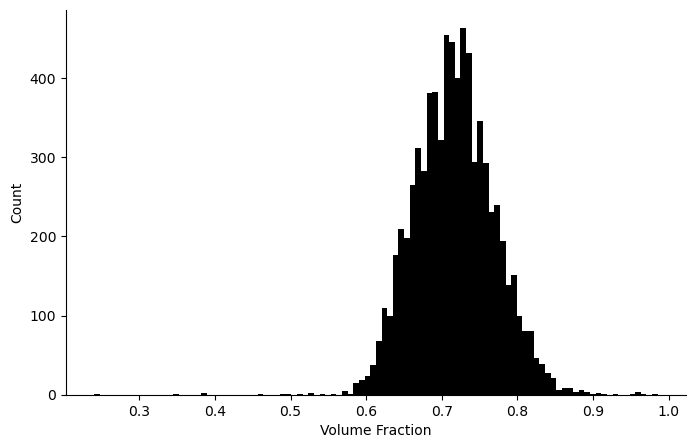

In [89]:
plt.figure(figsize=(8,5))
plt.hist(Y[:,4],100, color="black");
plt.xlabel("Volume Fraction")
plt.ylabel("Count")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Now lets take a look at our other y values:

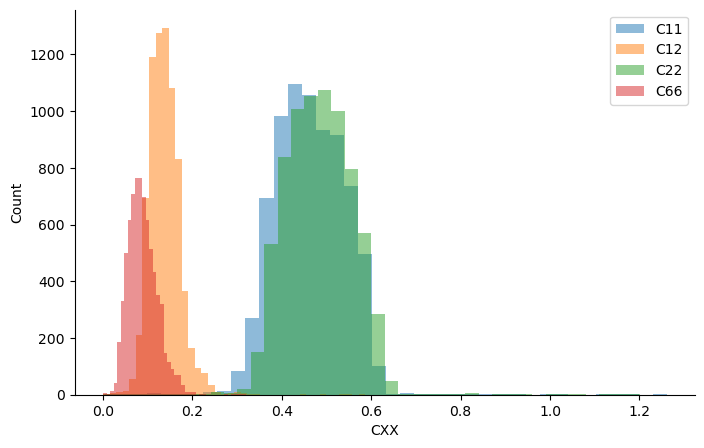

In [90]:
plt.figure(figsize=(8,5))
names=["C11", "C12", "C22", "C66"]
for i in range(4):
  plt.hist(Y[:,i], bins=40, alpha=0.5, label=names[i]);
plt.legend(loc='upper right')
plt.xlabel("CXX")
plt.ylabel("Count")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Finally, let's make a little pairplot to look at pairwise distributions of stiffness/volume fraction values.

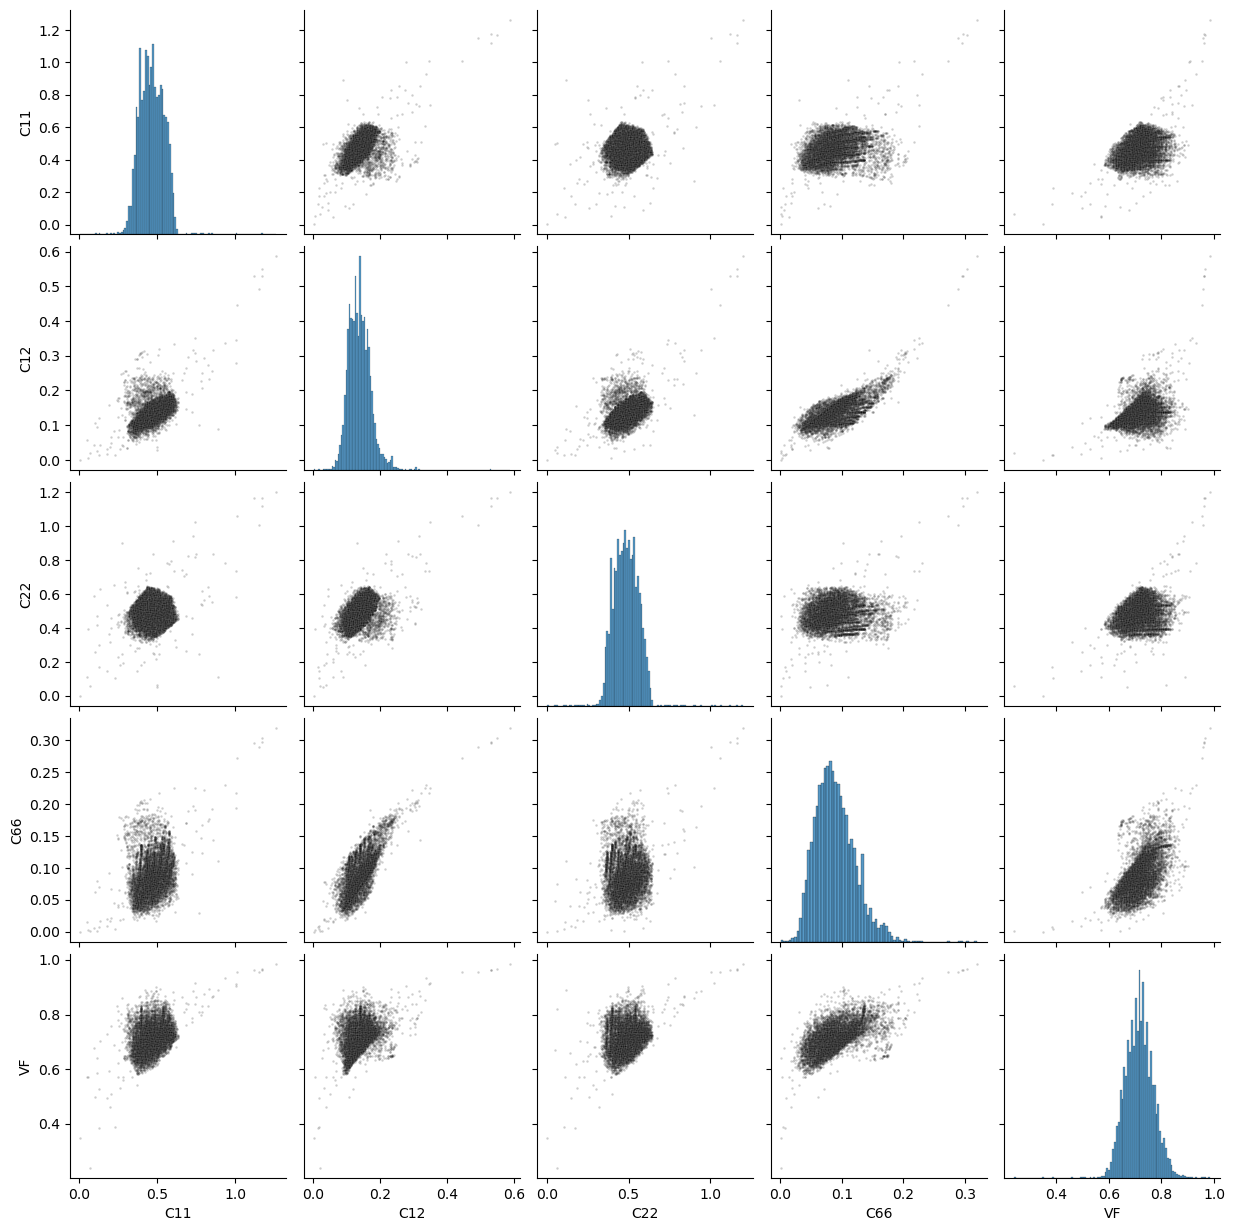

In [91]:
df = pd.DataFrame(Y, columns=["C11", "C12", "C22", "C66", "VF"])
pairplot = sns.pairplot(df, plot_kws={'s': 3, 'color': 'black', 'alpha': 0.2})
plt.show()

We can see that we have a diverse set of metamaterial unit cells with hugely differing volume fractions. How can we predict the stiffness of each unit cell in each principle direction?

# Neural Network Training

Now that we have examined the data, we are ready for training! We will set some of the training data aside for validation. We do this because we want to check how the model is performing on data it has never seen before. Sometimes a model can overfit to the data it sees during training, but perform poorly on data outside this training set. We can get an understanding of how our models are doing on data they don't see during training by evaluating their performance on a smaller subset of the data, which we set aside for validating the performance of the model. Here, we will keep 80% of our datapoints for training and leave the rest for validation:

In [92]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=.2, random_state=42)

## Deep Neural Network

We will first train a deep neural network. First, we create a class for the model, create an instance of the model, then print a summary of the model.

In [93]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # Flatten layer to convert 50x50 images into a 2500-dimensional vector
        self.flatten = nn.Flatten()

        # Define fully connected layers
        self.fc1 = nn.Linear(50 * 50, 64)  # Input size is 50x50, output size is 64
        self.fc2 = nn.Linear(64, 64)       # 64 inputs, 64 outputs
        self.fc3 = nn.Linear(64, 5)        # 64 inputs, 5 outputs (for 5 output classes)

    def forward(self, x): # Call all the layers in this function
        # Flatten the input image
        x = self.flatten(x)  # [batch x 2500]

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))  # [batch x 64]
        x = F.relu(self.fc2(x))  # [batch x 64]

        # Output layer (no activation for final regression layer)
        x = self.fc3(x)  # [batch x 5]
        return x

# Create a DNN model instance
model_dnn = DNN()
model_dnn.to(device)

# Print the model's architecture for reference
summary(model_dnn, input_size=(1, 50, 50))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2500]               0
            Linear-2                   [-1, 64]         160,064
            Linear-3                   [-1, 64]           4,160
            Linear-4                    [-1, 5]             325
Total params: 164,549
Trainable params: 164,549
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.63
Estimated Total Size (MB): 0.66
----------------------------------------------------------------


Next, we create a training loop for the model. We will create this in a function that we can reuse for both the DNN and CNN (coming later) training.

In [94]:
def train_model(model, X_train, Y_train, X_validation, Y_validation, num_epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    """
    Function to train a given model (CNN or DNN) using training and validation data.

    Args:
    - model: The model to train (e.g., CNN or DNN).
    - X_train: Training data (features).
    - Y_train: Training data (labels).
    - X_validation: Validation data (features).
    - Y_validation: Validation data (labels).
    - num_epochs: Number of training epochs (default: 10).
    - batch_size: Batch size for training (default: 32).
    - learning_rate: Learning rate for the optimizer (default: 0.001).
    - device: Device to run the model on ('cuda' or 'cpu').

    Returns:
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    """

    # Move model to the specified device (GPU or CPU)
    model = model.to(device)

    # Define loss function (Mean Squared Error for regression tasks)
    criterion = nn.MSELoss()

    # Define optimizer (Adam optimizer with specified learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for batching the training data
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for batching the validation data
    validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(Y_validation, dtype=torch.float32))
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store train and validation losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Using tqdm for the training loop progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)

        # Iterate over batches of training data
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
            labels = labels.to(device)  # Move labels to device (GPU/CPU)

            # Zero the gradients before the next update
            optimizer.zero_grad()

            # Forward pass: compute model outputs
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Perform a single optimization step (update model parameters)
            optimizer.step()

            # Accumulate loss over the batch
            running_loss += loss.item() * inputs.size(0)

            # Update tqdm progress bar with current loss
            train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader.dataset)})

        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation loop (no gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute model outputs
                outputs = model(inputs)

                # Compute validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss for the epoch
        val_loss /= len(validation_loader.dataset)
        val_losses.append(val_loss)

        # Print the train and validation loss at the end of each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train MSE: {epoch_loss:.4f} - Validation MSE: {val_loss:.4f}')

    print("Training complete.")

    # Return the recorded training and validation losses
    return train_losses, val_losses


Time to call the trianing function and train our model!

In [95]:
dnn_train_losses, dnn_val_losses = train_model(model_dnn, X_train, Y_train, X_validation, Y_validation, num_epochs=20, device=device)

Epoch [1/20] - Train MSE: 0.0049 - Validation MSE: 0.0020


Epoch [2/20] - Train MSE: 0.0014 - Validation MSE: 0.0016


Epoch [3/20] - Train MSE: 0.0012 - Validation MSE: 0.0015


Epoch [4/20] - Train MSE: 0.0011 - Validation MSE: 0.0014


Epoch [5/20] - Train MSE: 0.0011 - Validation MSE: 0.0013


Epoch [6/20] - Train MSE: 0.0010 - Validation MSE: 0.0015


Epoch [7/20] - Train MSE: 0.0010 - Validation MSE: 0.0012


Epoch [8/20] - Train MSE: 0.0009 - Validation MSE: 0.0012


Epoch [9/20] - Train MSE: 0.0009 - Validation MSE: 0.0012


Epoch [10/20] - Train MSE: 0.0009 - Validation MSE: 0.0013


Epoch [11/20] - Train MSE: 0.0008 - Validation MSE: 0.0013


Epoch [12/20] - Train MSE: 0.0008 - Validation MSE: 0.0012


Epoch [13/20] - Train MSE: 0.0008 - Validation MSE: 0.0011


Epoch [14/20] - Train MSE: 0.0008 - Validation MSE: 0.0013


Epoch [15/20] - Train MSE: 0.0009 - Validation MSE: 0.0011


Epoch [16/20] - Train MSE: 0.0007 - Validation MSE: 0.0013


Epoch [17/20] - Train MSE: 0.0007 - Validation MSE: 0.0012


Epoch [18/20] - Train MSE: 0.0008 - Validation MSE: 0.0012


Epoch [19/20] - Train MSE: 0.0007 - Validation MSE: 0.0010


Epoch [20/20] - Train MSE: 0.0007 - Validation MSE: 0.0013
Training complete.


Now, lets plot the convergence of our model. We should see that the Mean Squared Error (MSE) improves for both the training and validation data.

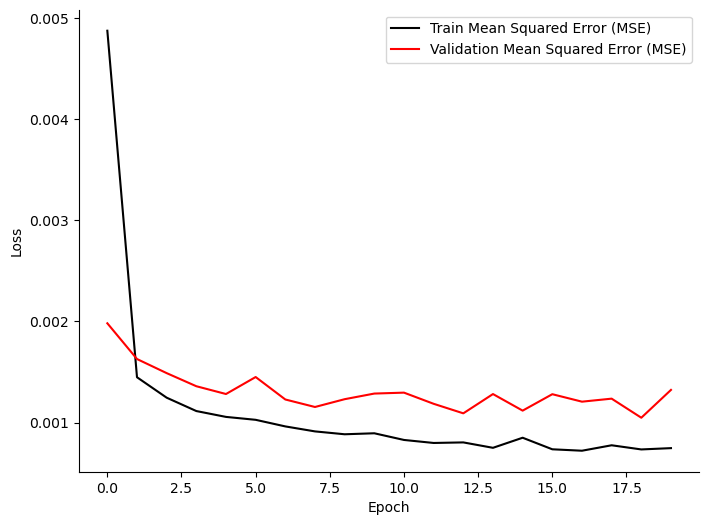

In [96]:
def plot_convergence(train_losses, val_losses):
    """
    Function to plot the training and validation loss convergence over epochs.

    Args:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot training and validation losses
    plt.plot(train_losses, label='Train Mean Squared Error (MSE)', color="black")
    plt.plot(val_losses, label='Validation Mean Squared Error (MSE)', color="red")

    # Label the axes
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Add legend in the upper right corner
    plt.legend(loc='upper right')

    # Remove the top and right borders
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

plot_convergence(dnn_train_losses, dnn_val_losses)

As you can see, the model makes better predictions in the training data then it does on the validation data, which is indicative of what you may see when you submit your predictions for the test data. Now, lets look at some scatterplots to compare our model's predicted values with the ground truth values from the validation set.

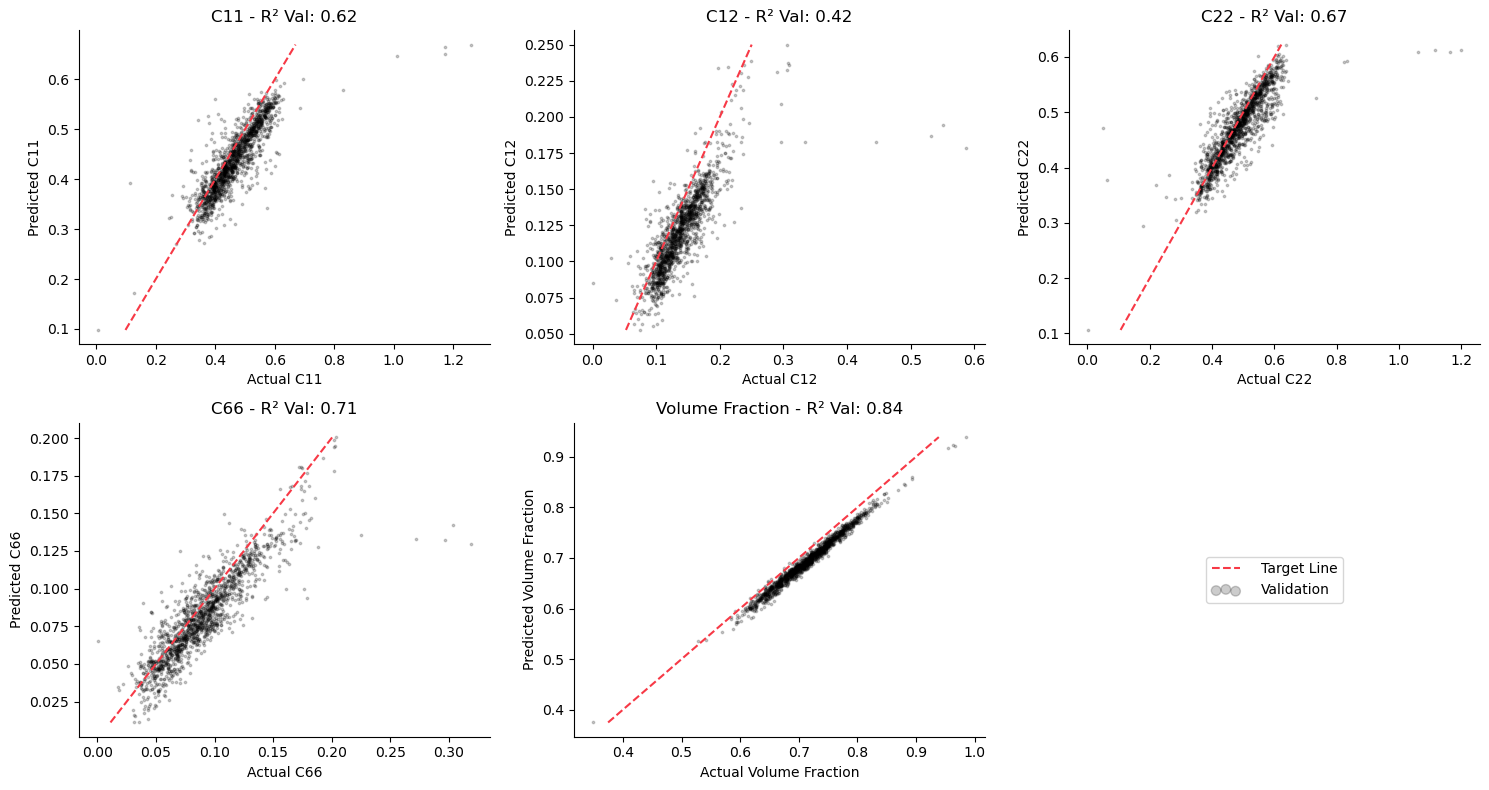

In [97]:
def plot_predictions_with_r2(model, X_validation, Y_validation, X_test, Y_test, device, names=None, show_test=True):
    """
    Function to plot actual vs predicted values for validation and optionally test datasets,
    display R² scores in the subplot titles, and add a legend in the last (unused) subplot.

    Args:
    - model: The trained model (DNN or CNN) used for making predictions.
    - X_validation: Validation feature data.
    - Y_validation: Validation target data.
    - X_test: Test feature data.
    - Y_test: Test target data.
    - device: The device (GPU or CPU) on which the model is running.
    - names: List of names for the target variables (default: None).
    - show_test: Boolean flag to control whether to show test data or only validation data (default: True).
    """

    if names is None:
        names = ["C11", "C12", "C22", "C66", "Volume Fraction"]  # Default names for target variables

    # Generate predictions for the validation and test sets
    val_pred = model(torch.tensor(X_validation, dtype=torch.float32).to(device)).cpu().detach().numpy()

    if show_test:
        test_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

    # Create a figure with 2x3 subplots (6 in total)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    # Loop over the target variables (assuming 5 here)
    for i in range(5):
        # Calculate the R² score for validation and test sets
        r2_val = r2_score(Y_validation[:, i], val_pred[:, i])

        if show_test:
            r2_test = r2_score(Y_test[:, i], test_pred[:, i])

        # Plot actual vs predicted for validation (and optionally test) sets
        ax = axs[i // 3, i % 3]  # Subplot position

        if show_test:
            # Plot test data if the flag is set to True
            ax.scatter(Y_test[:, i], test_pred[:, i], s=3, color="#32a895", alpha=0.2, label='Test')

            # Plot the ideal 1:1 line (using ranges from test)
            ax.plot([min(test_pred[:, i]), max(test_pred[:, i])],
                    [min(test_pred[:, i]), max(test_pred[:, i])], color='#f73946', linestyle='--', label='Target Line')
        else:
            # Plot the ideal 1:1 line (using ranges from val)
            ax.plot([min(val_pred[:, i]), max(val_pred[:, i])],
                    [min(val_pred[:, i]), max(val_pred[:, i])], color='#f73946', linestyle='--', label='Target Line')

        # Plot validation data
        ax.scatter(Y_validation[:, i], val_pred[:, i], s=3, color="black", alpha=0.2, label='Validation')

        # Set labels for the axes
        ax.set_xlabel(f"Actual {names[i]}")
        ax.set_ylabel(f"Predicted {names[i]}")

        # Add the R² scores to the title of each subplot
        if show_test:
            ax.set_title(f"{names[i]} - R² Val: {r2_val:.2f}, R² Test: {r2_test:.2f}")
        else:
            ax.set_title(f"{names[i]} - R² Val: {r2_val:.2f}")

        # Remove the top and right borders for a cleaner look
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Add legend in the last subplot (bottom right, unfilled one)
    axs[1, 2].axis('off')  # Turn off the empty subplot
    handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from previous plots

    # Make points in the legend larger by adjusting 'scatterpoints' and 'markerscale'
    axs[1, 2].legend(handles, labels, loc='center', scatterpoints=3, markerscale=4, handletextpad=1.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



plot_predictions_with_r2(model_dnn, X_validation, Y_validation, X_test, Y_test, device, show_test=False)



Perfect predictions would lie directly on the x=y line, but we can see that most of the scatterplots are fairly tight around this line. When the model tries to predict points that lie further away from the rest of the training data, the predictions become less accurate. Finding a way to address this issue might help on the test data, since it may not have the same data distribution as the training data!

Now lets overlay this on the test set predictions.


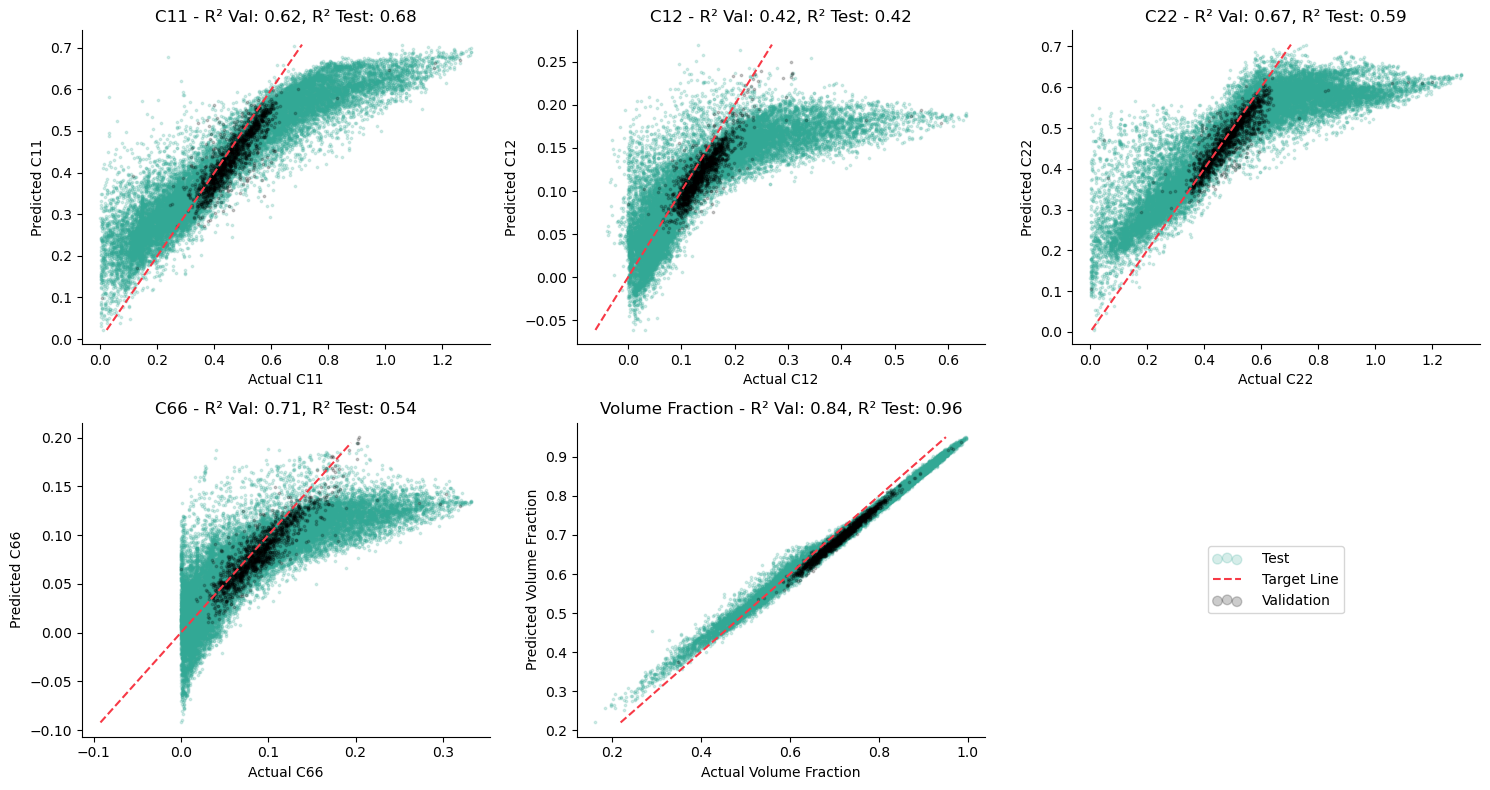

In [98]:
plot_predictions_with_r2(model_dnn, X_validation, Y_validation, X_test, Y_test, device, show_test=True)


If you haven't changed the original code, you should see that these results are much poorer than what we were expecting. What happaned? Well, the train dataset isn't guaranteed to be sampled from the same distribution as the test dataset. In fact, we can see that the training data features stress values that are largely out of the distribution of the training data. These are the datapoints that the model struggles most on! Keep in mind that in a normal hackathon/challenge problem setting, we would not have the luxury of seeing these curves. We would have to do our best to make our model as robust and generalizable as possible without having feedback on our performance on the test set, aside from perhaps a single score value.

## Convolutional Neural Networks

Next, we try convolutional neural networks. These operate by sliding a convolution image over spatially grouped data, such as images, offering a means to exploit spatial locality of adjacent datapoints. We define a CNN model below:

In [99]:
class CNN(nn.Module):
    def __init__(self):  # Define all the layers here
        super(CNN, self).__init__()
        # All pooling will use 2x2 window and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Conv layer: 1 input channel (grayscale), 4 output channels, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

        # Second Conv layer: 4 input channels, 8 output channels
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

        # Third Conv layer: 8 input channels, 16 output channels
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Fourth Conv layer: 16 input channels, 32 output channels
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Operation to flatten the images into a vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 3 * 3, 16)  # Adjusted to match the output size after conv3
        self.fc2 = nn.Linear(16, 5)  # 5 output classes

    def forward(self, x):  # Call all the layers in this function
        # Reshape the input to ensure it has the correct channel dimension: [batch x 1 x 50 x 50]
        if len(x.shape) == 3:  # Input is [batch x 50 x 50]
            x = x.unsqueeze(1)  # Add channel dimension -> [batch x 1 x 50 x 50]

        # Convolve, then pass through ReLU, then pooling
        x = F.relu(self.conv1(x))  # [batch x 4 x 50 x 50]
        x = self.pool(x)  # [batch x 4 x 25 x 25]

        x = F.relu(self.conv2(x))  # [batch x 8 x 25 x 25]
        x = self.pool(x)  # [batch x 8 x 12 x 12]

        x = F.relu(self.conv3(x))  # [batch x 16 x 12 x 12]
        x = self.pool(x)  # [batch x 16 x 6 x 6]

        x = F.relu(self.conv4(x))  # [batch x 32 x 6 x 6]
        x = self.pool(x)  # [batch x 32 x 3 x 3]

        x = self.flatten(x)  # Flatten for the fully connected layer [batch x 288]

        # Pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))  # [batch x 16]

        # Final fully connected layer with no activation (since we are doing regression)
        x = self.fc2(x)  # Output layer with 5 outputs [batch x 5]
        return x

# Create a CNN model instance
model_cnn = CNN()
model_cnn.to(device)

# Print the model's architecture
summary(model_cnn, input_size=(1, 50, 50))  # Adjusted input size for grayscale images with 1 channel


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 50, 50]              40
         MaxPool2d-2            [-1, 4, 25, 25]               0
            Conv2d-3            [-1, 8, 25, 25]             296
         MaxPool2d-4            [-1, 8, 12, 12]               0
            Conv2d-5           [-1, 16, 12, 12]           1,168
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Conv2d-7             [-1, 32, 6, 6]           4,640
         MaxPool2d-8             [-1, 32, 3, 3]               0
           Flatten-9                  [-1, 288]               0
           Linear-10                   [-1, 16]           4,624
           Linear-11                    [-1, 5]              85
Total params: 10,853
Trainable params: 10,853
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [100]:
cnn_train_losses, cnn_val_losses = train_model(model_cnn, X_train, Y_train, X_validation, Y_validation, num_epochs=20, device=device)

Epoch [1/20] - Train MSE: 0.0114 - Validation MSE: 0.0040


Epoch [2/20] - Train MSE: 0.0033 - Validation MSE: 0.0037


Epoch [3/20] - Train MSE: 0.0029 - Validation MSE: 0.0031


Epoch [4/20] - Train MSE: 0.0024 - Validation MSE: 0.0027


Epoch [5/20] - Train MSE: 0.0020 - Validation MSE: 0.0022


Epoch [6/20] - Train MSE: 0.0017 - Validation MSE: 0.0019


Epoch [7/20] - Train MSE: 0.0015 - Validation MSE: 0.0017


Epoch [8/20] - Train MSE: 0.0012 - Validation MSE: 0.0013


Epoch [9/20] - Train MSE: 0.0010 - Validation MSE: 0.0011


Epoch [10/20] - Train MSE: 0.0009 - Validation MSE: 0.0011


Epoch [11/20] - Train MSE: 0.0008 - Validation MSE: 0.0009


Epoch [12/20] - Train MSE: 0.0008 - Validation MSE: 0.0009


Epoch [13/20] - Train MSE: 0.0007 - Validation MSE: 0.0009


Epoch [14/20] - Train MSE: 0.0006 - Validation MSE: 0.0009


Epoch [15/20] - Train MSE: 0.0006 - Validation MSE: 0.0007


Epoch [16/20] - Train MSE: 0.0006 - Validation MSE: 0.0007


Epoch [17/20] - Train MSE: 0.0005 - Validation MSE: 0.0006


Epoch [18/20] - Train MSE: 0.0005 - Validation MSE: 0.0006


Epoch [19/20] - Train MSE: 0.0004 - Validation MSE: 0.0006


Epoch [20/20] - Train MSE: 0.0004 - Validation MSE: 0.0006
Training complete.


Let's check the convergence:

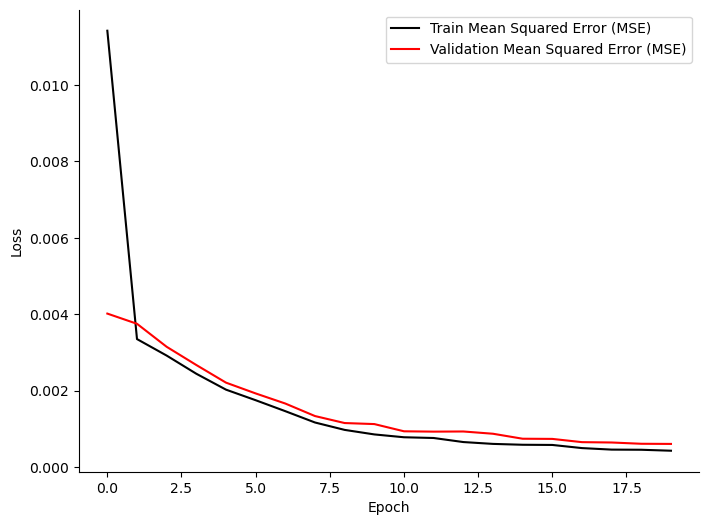

In [101]:
plot_convergence(cnn_train_losses, cnn_val_losses)

Time for regression plots!

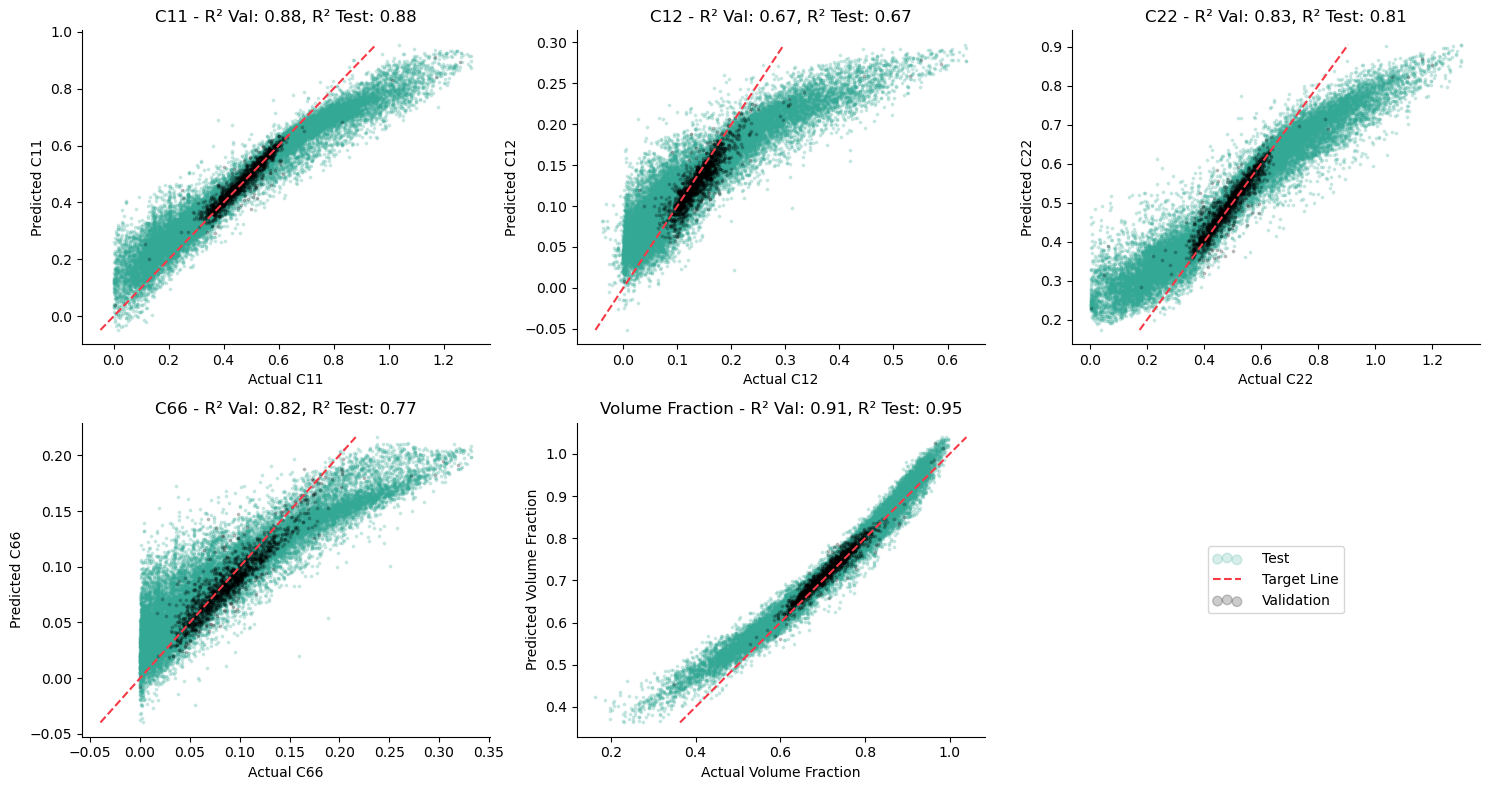

In [102]:
plot_predictions_with_r2(model_cnn, X_validation, Y_validation, X_test, Y_test, device, show_test=True)

How did the CNN compare to the DNN?

# Demo Assignment

## Pt 1. 

You may notice that predicted values tend to be less accurate for extreme values. In a previous demo, we explored class weighting in classification problems.  Class weighting can be adapted to regression problems and hypothesize how this may affect regression performance.

**Please test out some class weighting, data augmentation, data oversampling or some strategy independent of the model architecture that might improve training.**

### Process

 - I wrote the below code (with some help from an LLM), which augments and scales the data in a few ways.
 - I ran the code a bunch of times with different parts of it commented out.
 - For each run, I wrote a short reflection on its effects *as compared to the results above (baseline with no augmentation or scaling)*
 - *Then, I updated the code to re-calculate the volume fraction, and ran the best combination of scaling + augmentation that I had found previously.*

### Results

| Scaling             | Data Augmentation    | Recalc Vol Frac? | Impact on Results                                                  | Volume Fraction R2 score |
|---------------------|----------------------|------------------|--------------------------------------------------------------------|--------------------------|
| Standard Scaling    | No Augmentation      | No               | All predictions got significantly worse                            | -14.5 :\( |
| No Scaling          | Rotating only        | No               | Slightly improved C11, C66, and Vol Frac. Others got (much) worse. | 0.99 |
| No scaling          | Flipping only        | No               | Slightly improved C12, C66, and Vol Frac. Others got (much) worse. | 0.99 |
| No scaling          | Add noise only       | No               | Slightly improved C12, C66, and Vol Frac. Others got (much) worse. | 0.99 |
| No scaling          | Rot, Flip, and noise | No               | Slightly improved C12, C66, and Vol Frac. Others got (much) worse. | 0.99 |
| No scaling          | Rot, Flip, and noise | Yes              | Slightly improved C12, C66, and Vol Frac. Others got (much) worse. | 0.98 |

### Reflection

Of all of the things I tested, data augmentation (the more the better) seemed to yield the most improvement for predicting the volume fraction. It seems that re-calculating the volume fraction for the augmented data did not help - this is probably because the augmentation that I tried were simple transformations which should not have changed the volume fraction; there was no need to recalculate it from the original data set.

Scaling seemed to hurt performance more than help, though I didn't try any more advanced scaling methods.

The features which did not benefit from data augmentation were those with a more complex relationship to the shape. This is because my data augmentation method was indeed so simple, and these other features were just copied from the original datapoint. So flipping and rotating the input image without updating the features made prediction of those features much less acurate. This shows the importance of understanding your data when atempting to augment it!

### (Code below)

Epoch [1/20] - Train MSE: 0.0011 - Validation MSE: 0.0012


Epoch [2/20] - Train MSE: 0.0011 - Validation MSE: 0.0012


Epoch [3/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [4/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [5/20] - Train MSE: 0.0011 - Validation MSE: 0.0012


Epoch [6/20] - Train MSE: 0.0011 - Validation MSE: 0.0013


Epoch [7/20] - Train MSE: 0.0011 - Validation MSE: 0.0012


Epoch [8/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [9/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [10/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [11/20] - Train MSE: 0.0011 - Validation MSE: 0.0011


Epoch [12/20] - Train MSE: 0.0010 - Validation MSE: 0.0011


Epoch [13/20] - Train MSE: 0.0010 - Validation MSE: 0.0012


Epoch [14/20] - Train MSE: 0.0010 - Validation MSE: 0.0011


Epoch [15/20] - Train MSE: 0.0010 - Validation MSE: 0.0012


Epoch [16/20] - Train MSE: 0.0010 - Validation MSE: 0.0012


Epoch [17/20] - Train MSE: 0.0010 - Validation MSE: 0.0010


Epoch [18/20] - Train MSE: 0.0010 - Validation MSE: 0.0011


Epoch [19/20] - Train MSE: 0.0010 - Validation MSE: 0.0011


Epoch [20/20] - Train MSE: 0.0010 - Validation MSE: 0.0012
Training complete.


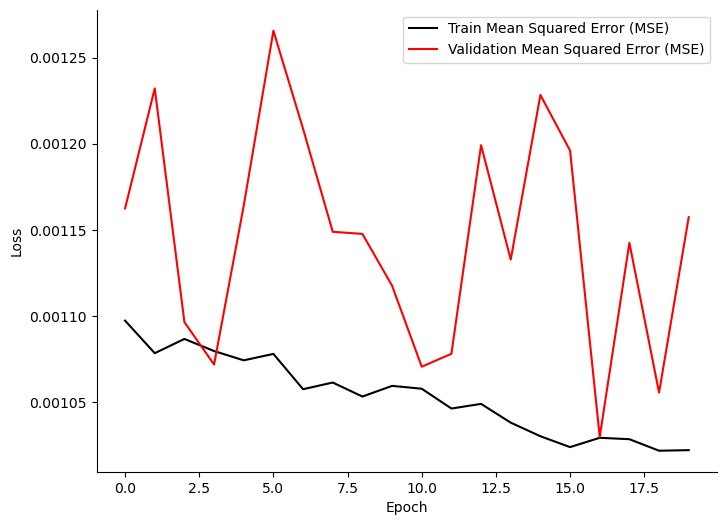

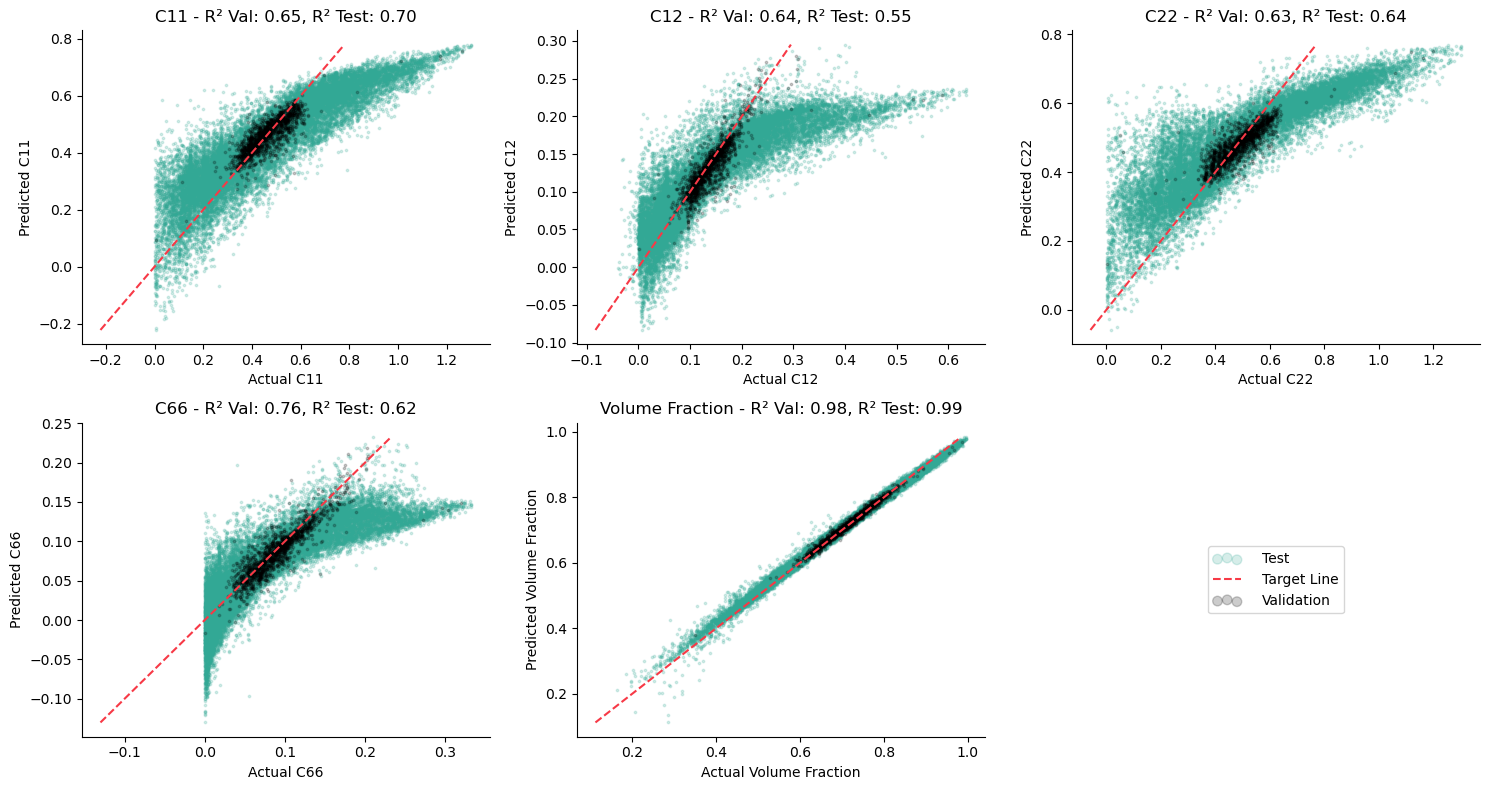

In [104]:
from sklearn.preprocessing import StandardScaler

# Data Augmentation Functions

def augment_data(X, Y):
    augmented_X = []
    augmented_Y = []
    
    for i in range(X.shape[0]):
        # Original image
        augmented_X.append(X[i])
        augmented_Y.append(Y[i])
        
        # Flipped image
        flipped_image = np.fliplr(X[i])
        augmented_X.append(flipped_image)
        augmented_Y.append(Y[i])
        
        # Rotated image
        rotated_image = np.rot90(X[i])
        augmented_X.append(rotated_image)
        augmented_Y.append(Y[i])
        
        # Adding noise
        noise = np.random.normal(0, 0.1, X[i].shape)
        noisy_image = X[i] + noise
        augmented_X.append(noisy_image)
        augmented_Y.append(Y[i])
    
    return np.array(augmented_X), np.array(augmented_Y)

def augment_data_with_recalc(X, Y):

    def calculate_volume_fraction(image):
        """
        Calculate the volume fraction of the given image.
        Volume fraction is the ratio of the number of True pixels to the total number of pixels.
        """
        return np.sum(image) / image.size

    augmented_X = []
    augmented_Y = []
    
    for i in range(X.shape[0]):
        # Original image
        augmented_X.append(X[i])
        augmented_Y.append(Y[i])
        
        # Flipped image
        flipped_image = np.fliplr(X[i])
        augmented_X.append(flipped_image)
        augmented_Y.append(np.append(Y[i][:4], calculate_volume_fraction(flipped_image)))
        
        # Rotated image
        rotated_image = np.rot90(X[i])
        augmented_X.append(rotated_image)
        augmented_Y.append(np.append(Y[i][:4], calculate_volume_fraction(rotated_image)))
        
        # Adding noise
        noise = np.random.normal(0, 0.1, X[i].shape)
        noisy_image = X[i] + noise
        augmented_X.append(noisy_image)
        augmented_Y.append(np.append(Y[i][:4], calculate_volume_fraction(noisy_image)))
    
    return np.array(augmented_X), np.array(augmented_Y)

# Augment the training data
X_train_aug, Y_train_aug = augment_data(X_train, Y_train)

# # Scaling the data
# X_train_aug_flat = X_train_aug.reshape(X_train_aug.shape[0], -1)
# scaler = StandardScaler()
# X_train_aug_flat = scaler.fit_transform(X_train_aug_flat)
# X_train_aug = X_train_aug_flat.reshape(X_train_aug_flat.shape[0], 50, 50)

# Train the model with augmented data
dnn_train_losses_aug, dnn_val_losses_aug = train_model(model_dnn, X_train_aug, Y_train_aug, X_validation, Y_validation, num_epochs=20, device=device)

# Plot the convergence
plot_convergence(dnn_train_losses_aug, dnn_val_losses_aug)

# Plot predictions with R2
plot_predictions_with_r2(model_dnn, X_validation, Y_validation, X_test, Y_test, device, show_test=True)


## Pt 2.

**Discuss how feature engineering can be used in this regression problem. For example, we can directly calculate volume fraction instead of predicting it. How might we be able to leverage volume fraction to make stronger predictions for the stiffness matrix entries? What are the best scores you achieve?**

Being able to directly calculate a feature rather than predicting it enables the following things:

 1. The feature can be used as an input to the model, for training. Perhaps the model can find some patterns in this data which improves prediciton.
 2. You can also caluclate this feature for datapoints that doen't have it, effectively augmenting training.



## Pt 3. 

**Do you see practical uses for these regressors? How can they be used to generate new metamaterial structures? What are some of the risks/assumptions?**

To generate new metamaterial structures, I suppose you could use the prediction as the objective function to minimize against. With an objective function, you could use GA and GD to generate new designs (explore the design space) and then optimize them (exploitation). The biggest downside to this is that prediction via NNs (as well as finding its gradient) takes much longer than a "traditional" objective function.

## Pt 4.

**We saw that the CNN model was much smaller (had fewer parameters) and often outperformed the DNN model (Particularly on the test set). Why? Specifically what is the advantage that the CNN brings to the table?**



## Pt 5.

**The models in this notebook are fairly erratic. Their performance has a lot of random variation. Comment on your observations.**

I did notice in Part 1 that sometimes I would get different R2 values.